In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Databases import 

In [2]:
### mirtarbase import
mirtarbase_path = '../data/MirTarBase/miRTarBase_MTI.csv'
mirtarbase_df = pd.read_csv(mirtarbase_path)
mirtarbase_df = mirtarbase_df[mirtarbase_df['Species (miRNA)'] == 'hsa'] # keep only human miRNA
mirtarbase_df['miRNA'] = mirtarbase_df['miRNA'].str.lower()



#### TCGA import
patients_path = '../data/TCGA/patients.csv'
patients =  pd.read_csv(patients_path)
pat_codes = list(patients.sample_code)

mirna_path = '../data/TCGA/miRNA_expression.xena.gz'
mirna_df = pd.read_csv(mirna_path, compression="gzip", sep="\t")
mirna_df['sample'] = mirna_df['sample'].str.lower()

mrna_path = '../data/TCGA/mRNA_expression.xena.gz'
mrna_df = pd.read_csv(mrna_path, compression="gzip", sep="\t")
mrna_df = mrna_df.drop_duplicates(subset='sample', keep=False) # SLC35E2 appears twice and is dropped


In [4]:
all_mirna_samples = set(mirna_df.columns)
all_mrna_samples = set(mrna_df.columns)
common_samples = all_mirna_samples.intersection(all_mrna_samples)
print(f'there are:\n-{len(all_mirna_samples)} unique samples for miRNAs\n-{len(all_mrna_samples)} unique samples for mRNAs\n-{len(common_samples)} unique common samples')

there are:
-10825 unique samples for miRNAs
-11070 unique samples for mRNAs
-10516 unique common samples


In [3]:
### to have some stats no need for filtering a priori
mirna_df = mirna_df[['sample'] + pat_codes] # keep only patients in our subset
mrna_df = mrna_df[['sample'] + pat_codes] # keep only patients in our subset
###
## now filtering based on mirtarbase connections
mirna_df= mirna_df[mirna_df['sample'].isin(mirtarbase_df['miRNA'].unique())]
mirtarbase_df = mirtarbase_df[mirtarbase_df['miRNA'].isin(mirna_df['sample'].unique())]

mrna_df = mrna_df[mrna_df['sample'].isin(mirtarbase_df['Target Gene'].unique())]
mirtarbase_df = mirtarbase_df[mirtarbase_df['Target Gene'].isin(mrna_df['sample'].unique())]
mrna_df = mrna_df.fillna(0.0)

mirna_df = mirna_df.set_index('sample')
mrna_df = mrna_df.set_index('sample')

## cleanup - final df for analyis
expression_df = pd.concat((mirna_df,mrna_df), axis=0)

# healty vs tumor Pearson similarity

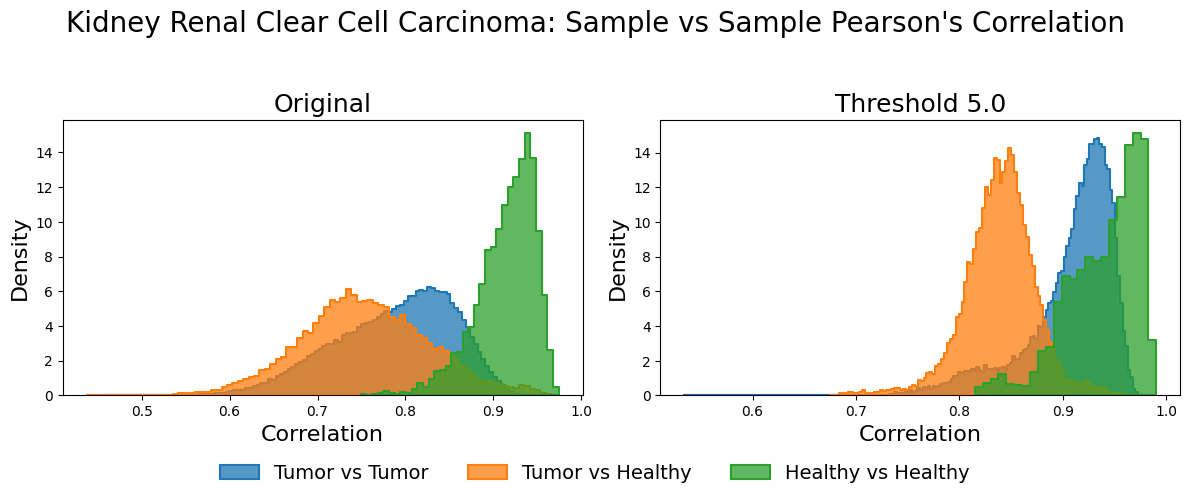

Figure saved to thesis_plots/Kidney renal clear cell carcinoma_pearson_histograms_thresh5.0.png


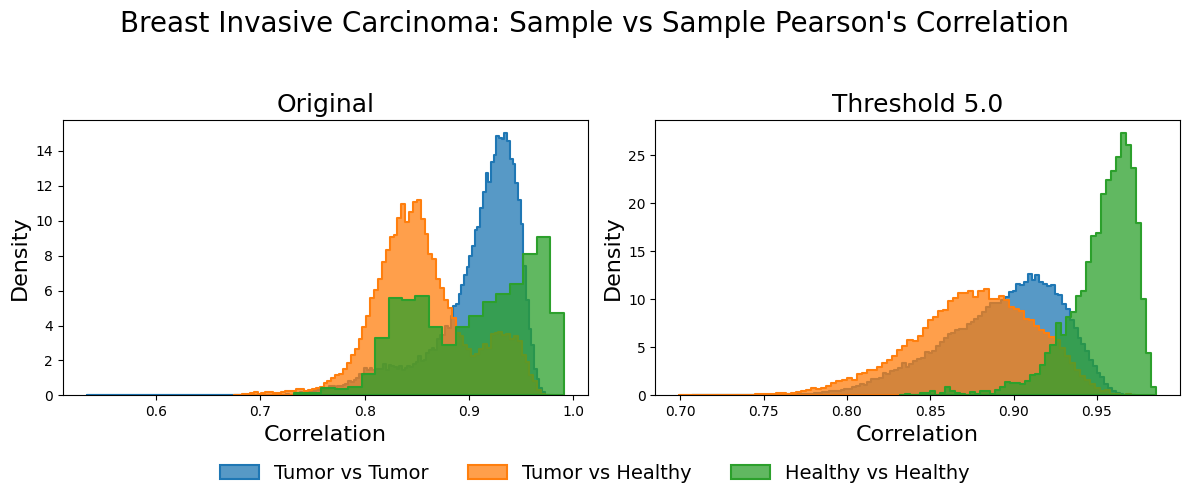

Figure saved to thesis_plots/Breast invasive carcinoma_pearson_histograms_thresh5.0.png


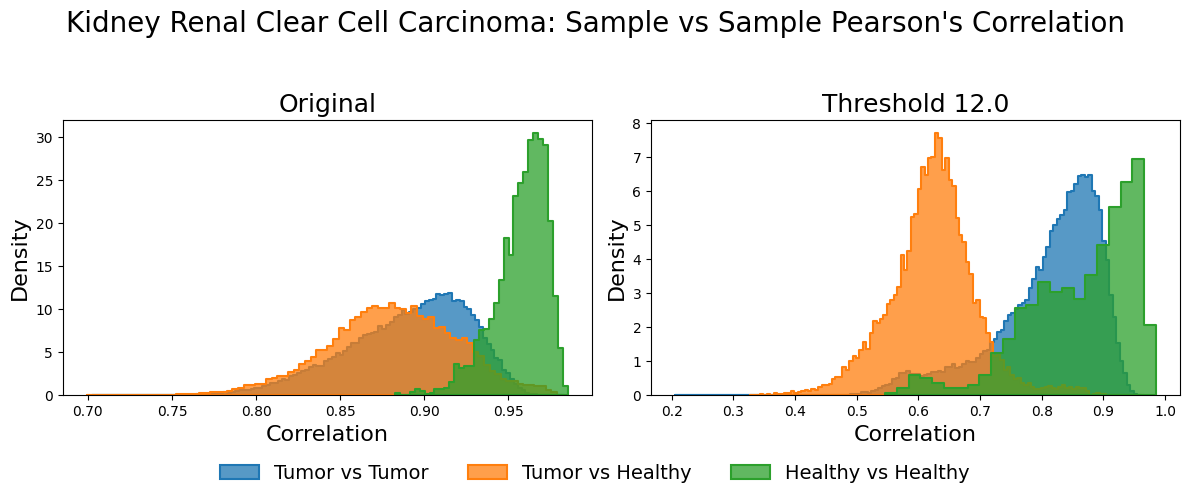

Figure saved to thesis_plots/Kidney renal clear cell carcinoma_pearson_histograms_thresh12.0.png


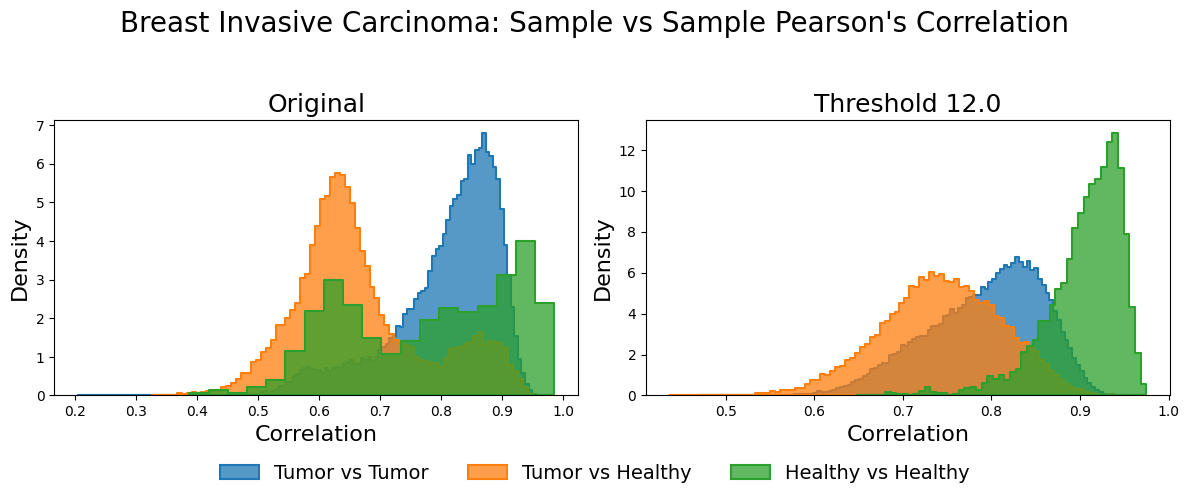

Figure saved to thesis_plots/Breast invasive carcinoma_pearson_histograms_thresh12.0.png


In [44]:
threshs = [5.0, 12.0]
for thresh in threshs:
    pearson_hvh, pearson_svh, pearson_svs = {}, {}, {}
    avg_corr_svh, avg_corr_hvh, avg_corr_svs = {}, {}, {}
    
    # all_studies = sick_patients['Study Name'].unique()
    all_studies = ["Kidney renal clear cell carcinoma", 'Breast invasive carcinoma']
    for study in all_studies:
        # healthy patients in the study
        healthy_study_codes = patients[(patients['study'] == study) & (patients['status'] == 'healthy')]
        healthy_study_exp = expression_df[healthy_study_codes['sample_code']]
        
        # sick patients in the study
        sick_study_codes = patients[(patients['study'] == study) & (patients['status'] == 'tumor')]
        sick_study_exp = expression_df[sick_study_codes['sample_code']]
    
        concat_df = pd.concat([healthy_study_exp, sick_study_exp], axis=1)
        filtered_df = concat_df[(concat_df > thresh).any(axis=1)]
        
        study_pearson_full = concat_df.corr(method='pearson')
        study_pearson_thresh = filtered_df.corr(method='pearson')
        
        # Determine where to draw the division line
        split_idx = healthy_study_exp.shape[1]  # number of healthy columns 
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for ax, study_pearson, subtitle in zip(
            axes,
            [study_pearson, study_pearson_thresh],
            ["Original", f"Threshold {thresh}"]
        ):
            pearson_hvh[study] = study_pearson.iloc[:split_idx, :split_idx]    
            pearson_svh[study] = study_pearson.iloc[:split_idx, split_idx:]
            pearson_svs[study] = study_pearson.iloc[split_idx:, split_idx:]
            
            hvh = pearson_hvh[study].to_numpy()
            svh = pearson_svh[study].to_numpy()
            svs = pearson_svs[study].to_numpy()
        
            upper_hvh = hvh[np.triu_indices_from(hvh, k=1)]
            upper_svs = svs[np.triu_indices_from(svs, k=1)]
            
            avg_corr_svh[study] = np.nanmean(svh)
            avg_corr_hvh[study] = np.nanmean(upper_hvh)
            avg_corr_svs[study] = np.nanmean(upper_svs)
        
            # Plot as histogram
            sns.histplot(upper_svs, label='Tumor vs Tumor', element="step", stat='density', ax=ax, linewidth=1.5)
            sns.histplot(svh.flatten(), label='Tumor vs Healthy', element="step", stat='density', ax=ax, linewidth=1.5)
            sns.histplot(upper_hvh, label='Healthy vs Healthy', element="step", stat='density', ax=ax, linewidth=1.5)
        
            ax.set_title(f"{subtitle}", fontsize=18)
            ax.set_xlabel("Correlation", fontsize=16)
            ax.set_ylabel("Density", fontsize=16)
            ax.tick_params(axis='both', labelsize=10)
        
        # Common legend below the plots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=14, frameon=False)
        
        # Main title
        fig.suptitle(f"{study.title()}: Sample vs Sample Pearson's Correlation", fontsize=20)
        
        # Adjust layout to make space for legend and title
        plt.tight_layout(rect=[0, 0.08, 1, 0.93])
        
        # Save and show
        save_path = f"thesis_plots/{study}_pearson_histograms_thresh{thresh}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Figure saved to {save_path}")


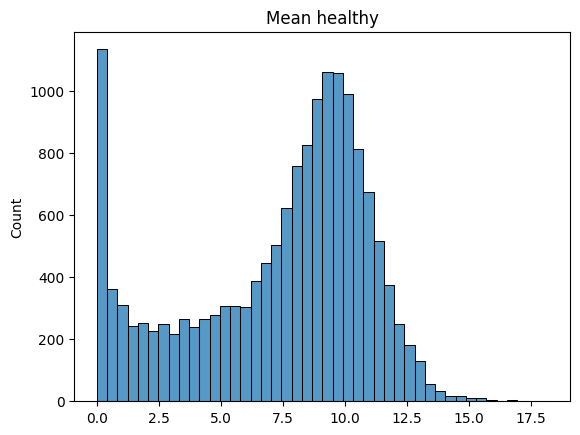

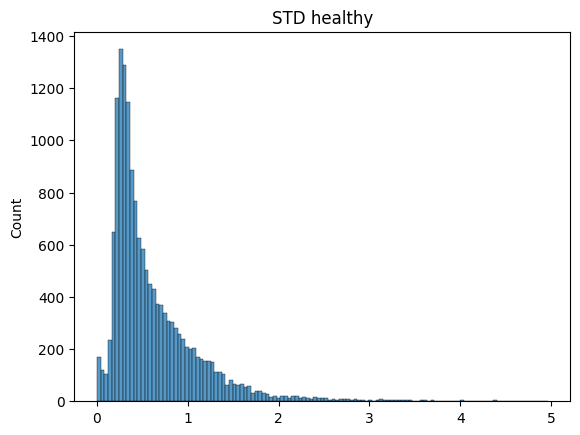

In [11]:
study = "Kidney renal clear cell carcinoma"

# healthy patients in the study
healthy_study_codes = patients[(patients['study'] == study) & (patients['status'] == 'healthy')]
healthy_study_exp = expression_df[healthy_study_codes['sample_code']]

mean_healthy = healthy_study_exp.mean(axis=1)
std_healthy = healthy_study_exp.std(axis=1)

sns.histplot(mean_healthy)
plt.title('Mean healthy')
plt.show()

sns.histplot(std_healthy)
plt.title('STD healthy')
plt.show()

# TISSUE ANALYSIS

In [4]:
import umap

/orfeo/cephfs/scratch/dssc/cmoret/RNAErnie/ernia_dgx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


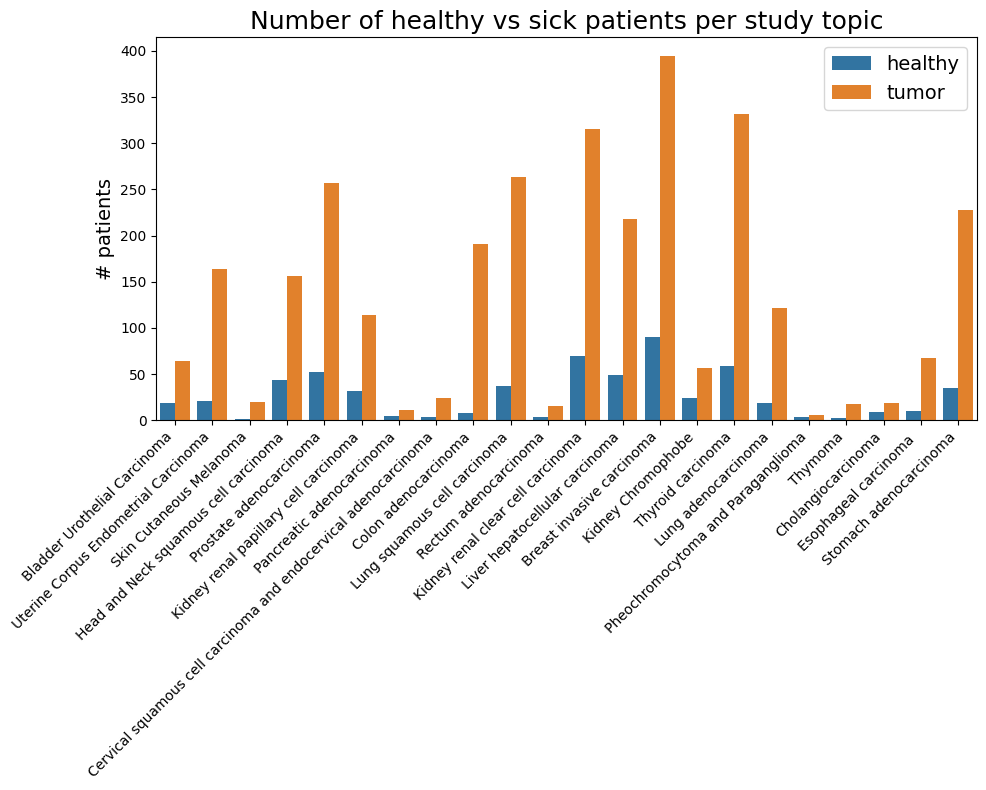

In [14]:
plt.figure(figsize=(10, 8))

sns.countplot(data=patients, x="study", hue="status")

plt.xticks(rotation=45, ha="right")
plt.ylabel("# patients", fontsize=14)
plt.xlabel("") 
plt.title("Number of healthy vs sick patients per study topic", fontsize=18)
plt.savefig("thesis_plots/svt_by_study.png", dpi=300)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [40]:
patients_status = patients.groupby(['study','status']).size().rename("count").reset_index()
patients_percent = patients.groupby('study')['status'].value_counts(normalize=True).mul(100).rename("percent").reset_index()
    # .reset_index()

In this section analyze tissue similarity

In [18]:
sample_corr = expression_df.corr(method='pearson')
corr_flat = sample_corr.stack().reset_index()

corr_flat.columns = ["sample1", "sample2", "corr"]
corr_flat = corr_flat[corr_flat["sample1"] != corr_flat["sample2"]]

sample_to_study = patients.set_index("sample_code")["study"].to_dict()

corr_flat["study1"] = corr_flat["sample1"].map(sample_to_study)
corr_flat["study2"] = corr_flat["sample2"].map(sample_to_study)
study_corr = corr_flat.groupby(["study1", "study2"])["corr"].mean().unstack()

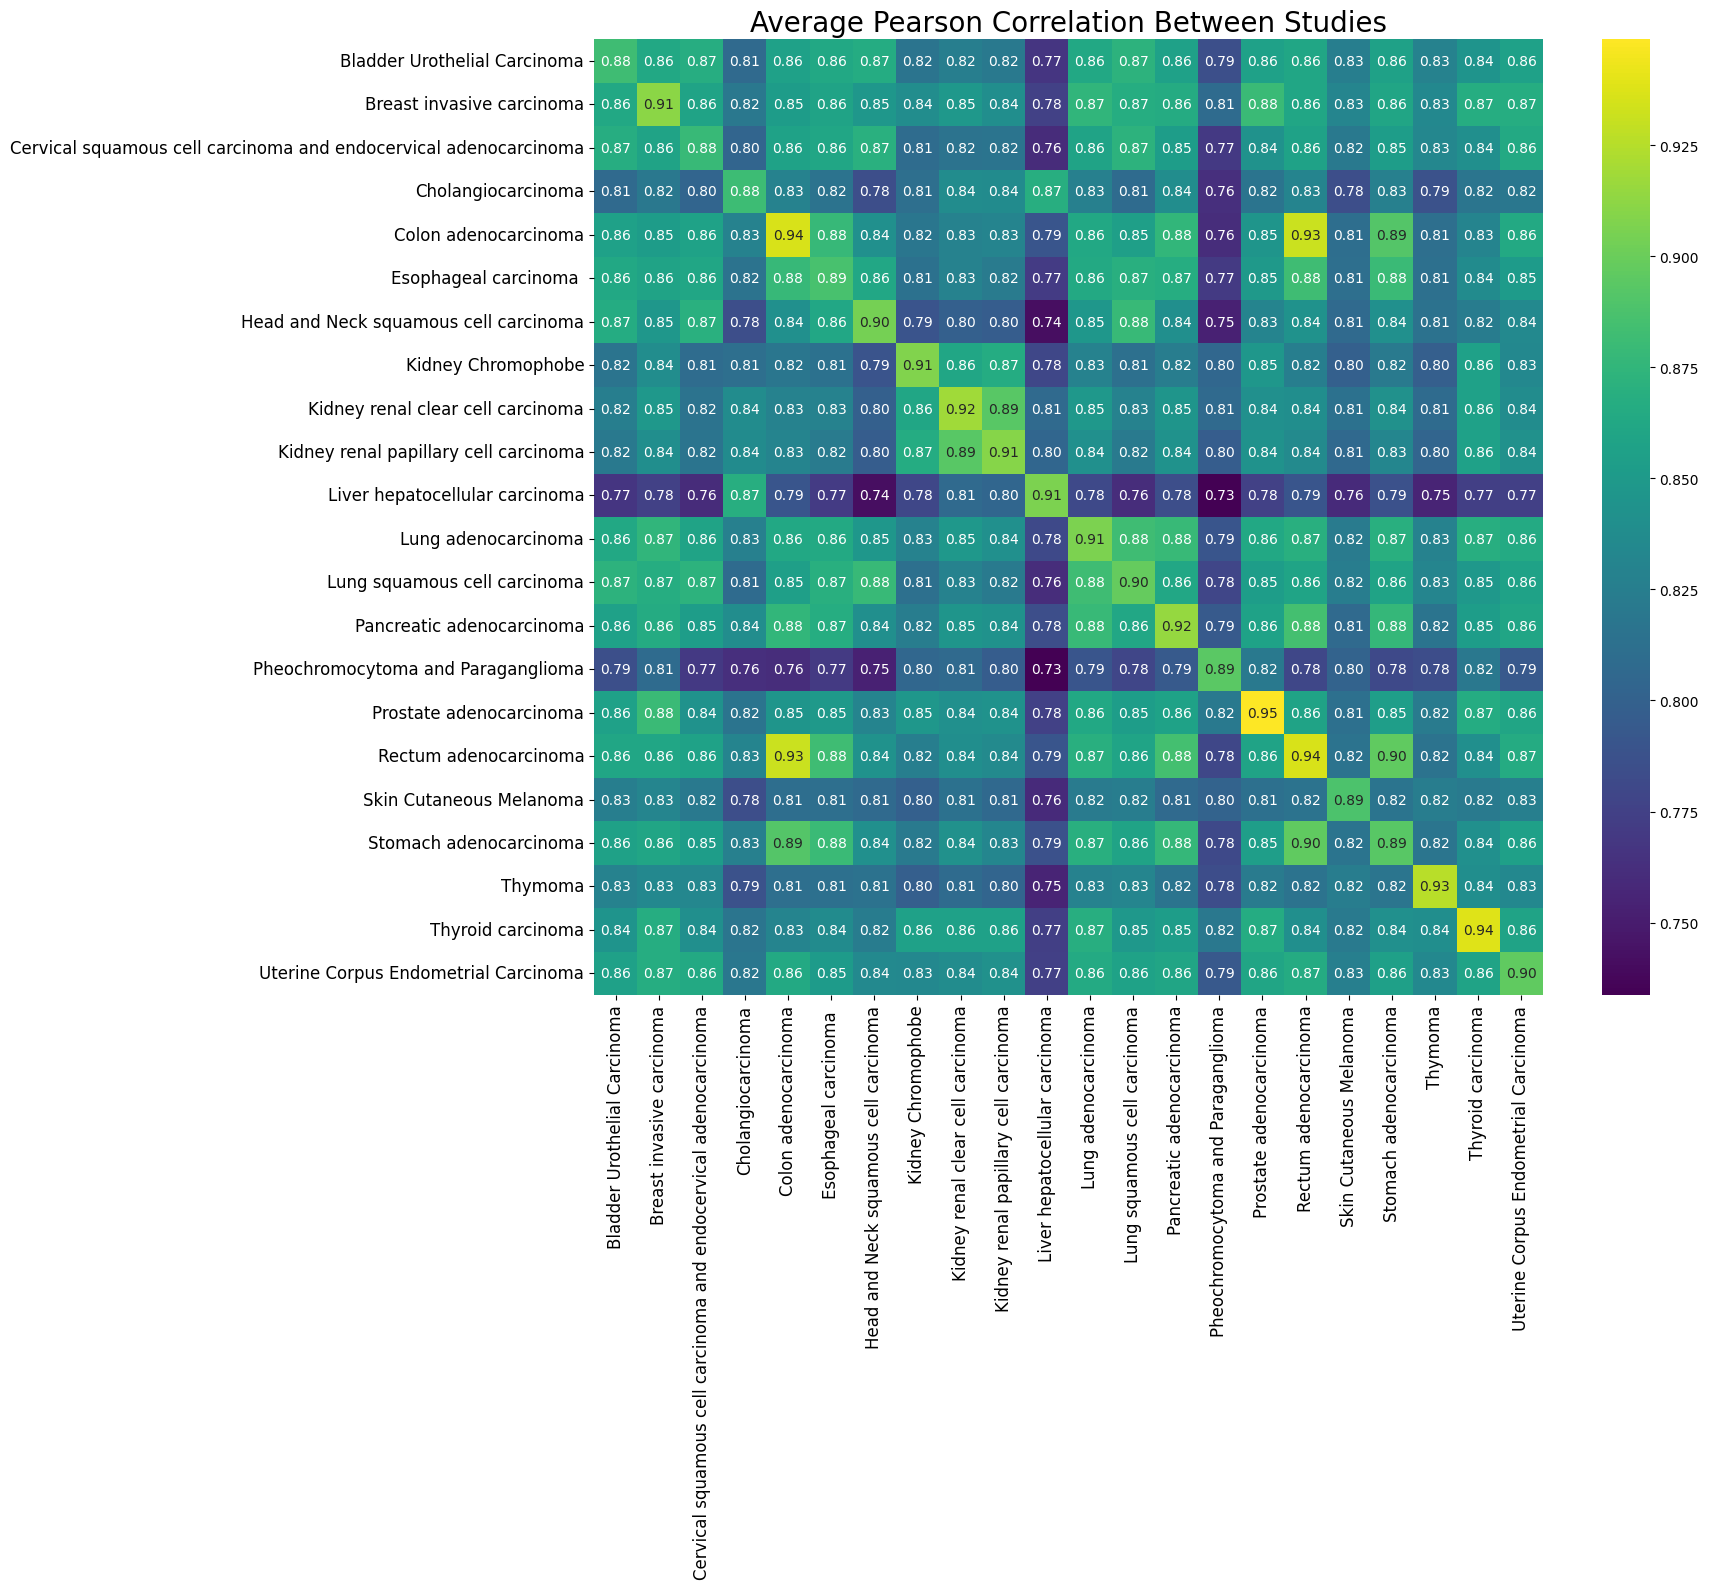

In [26]:
plt.figure(figsize=(18, 16))
sns.heatmap(study_corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Average Pearson Correlation Between Studies", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("") 
plt.ylabel("") 

plt.tight_layout()
plt.savefig("results/mean_pears_tissue.png", dpi=300)
plt.show()


UMAP projections of raw expression profiles

In [5]:
# SUBTYPING
# PATIENTS
# Combine patient data for labeling
# all_patients = pd.concat([healthy_patients, sick_patients])


# nodes
# pat_nodes = expression_df.drop(columns=['sample']).T 

reducer = umap.UMAP(n_neighbors=15, min_dist=0.8, metric='correlation')
umap_exp = reducer.fit_transform(expression_df.T)


/orfeo/cephfs/scratch/dssc/cmoret/RNAErnie/ernia_dgx/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


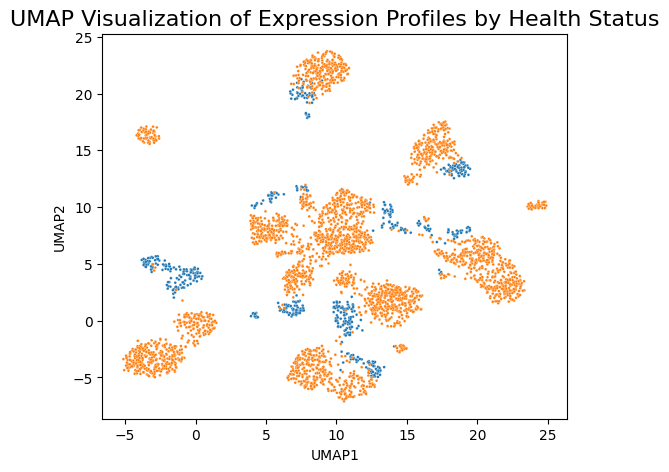

In [77]:
hvs_label_dict = dict(zip(patients['sample_code'], patients['status']))

# mirna labels
labels_hvs = pd.Categorical(expression_df.T.index.map(hvs_label_dict)) # create labels

# mirnas
umap_hvs_df = pd.DataFrame({
    'UMAP1': umap_exp[:, 0],
    'UMAP2': umap_exp[:, 1],
    'Label': labels_hvs
})

plt.figure(figsize=(6, 5))
# palette = sns.color_palette("husl", n_colors=umap_og_df["Label"].nunique())
sns.scatterplot(data=umap_hvs_df, x='UMAP1', y='UMAP2', hue='Label', s=4) #, palette=palette)
plt.title('UMAP Visualization of Expression Profiles by Health Status', fontsize=16)
plt.legend([], [], frameon=False) 
plt.savefig("thesis_plots/raw_umap_labeled_hvs.png", dpi=300)
plt.show()



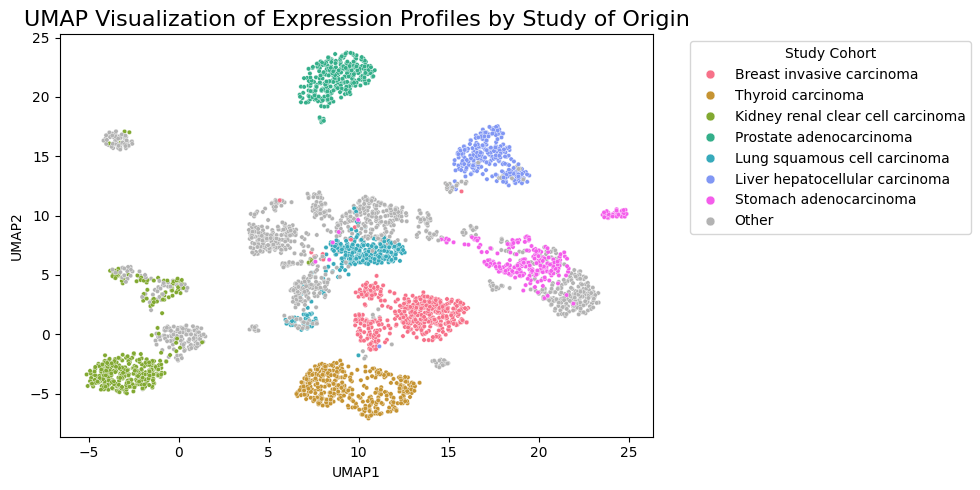

In [75]:
labels = umap_og_df["Label"].astype(str)

top_k = labels.value_counts().nlargest(7).index
umap_og_df["Label_simplified"] = labels.where(labels.isin(top_k), "Other")
categories = list(top_k) + ["Other"]

palette_colors = sns.color_palette("husl", n_colors=len(top_k)) + [(0.7, 0.7, 0.7)]  # gray for "Other"
palette = dict(zip(categories, palette_colors))

plt.figure(figsize=(10, 5))
ax = sns.scatterplot(
    data=umap_og_df,
    x='UMAP1', y='UMAP2',
    hue='Label_simplified',
    s=10,               # point size in the plot
    palette=palette
)
plt.title('UMAP Visualization of Expression Profiles by Study of Origin', fontsize=16)

# Get handles and labels from the plot
handles, labels_legend = ax.get_legend_handles_labels()

# Reorder legend according to your desired order
ordered_handles = []
ordered_labels = []
for cat in categories:
    if cat in labels_legend:
        idx = labels_legend.index(cat)
        ordered_handles.append(handles[idx])
        ordered_labels.append(labels_legend[idx])

# Create legend
legend = ax.legend(
    ordered_handles, ordered_labels,
    title="Study Cohort",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    markerscale=2
)

# Resize legend markers
# for handle in legend.handles:
#     handle.set_sizes([50])  # adjust 50 to your preferred size

plt.tight_layout()
plt.savefig("thesis_plots/raw_umap_labeled_topk_studies.png", dpi=300)

plt.show()


In [ ]:
 # healthy vs sick
label_dict_hvs = {code: 'healthy' for code in healthy_codes}
label_dict_hvs.update({code: 'tumor' for code in sick_codes})

# mirna
mirna_labels_hvs = pd.Categorical(pat_mirna.index.map(label_dict_hvs))

# genes
genes_labels_hvs = pd.Categorical(pat_genes.index.map(label_dict_hvs))

# mirnas
umap_mirna_hvs_df = pd.DataFrame({
    'UMAP1': umap_mirnas[:, 0],
    'UMAP2': umap_mirnas[:, 1],
    'Label': mirna_labels_hvs
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_mirna_hvs_df, x='UMAP1', y='UMAP2', hue='Label', s=4, palette='tab10')
plt.title('UMAP of miRNA expression profiles\ncolored by tissue status', fontsize=16)
plt.legend(title='Tissue status')
plt.savefig("results/mirnas_umap_labeled_hvs.png", dpi=300)
plt.show()


# genes
umap_genes_hvs_df = pd.DataFrame({
    'UMAP1': umap_genes[:, 0],
    'UMAP2': umap_genes[:, 1],
    'Label': genes_labels_hvs
})

plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_genes_hvs_df, x='UMAP1', y='UMAP2', hue='Label', s=4, palette='tab10')
plt.title('UMAP of gene expression profiles\ncolored by tissue status', fontsize=16)
plt.legend(title='Tissue status')
plt.savefig("results/genes_umap_labeled_hvs.png", dpi=300)
plt.show()

# MTI ANALYSIS

Veryfing power law assumpion with the 'powerlaw' library

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from network_experiments import *
import powerlaw



# study = "Kidney renal clear cell carcinoma"
study = "Breast invasive carcinoma"

dataset_tissue = load_mirna_dataset(status='all', make_undirected=True)

edges_df = dataset_tissue.df_edges

loaded mirna dataset
3648


Power-law alpha: 2.26, xmin: 26.0


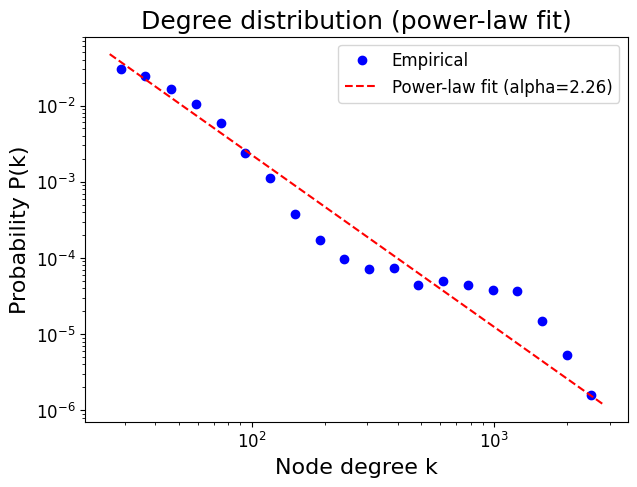

Log-likelihood ratio R: 3019.49, p-value: 1.5083e-128


In [3]:
# Fit using powerlaw

G = nx.from_pandas_edgelist(edges_df, source='miRNA', target='Target Gene')

degrees = [deg for node, deg in G.degree()]


degree_counts = np.bincount(degrees)
degree_values = np.arange(len(degree_counts))

fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
alpha = fit.alpha
xmin = fit.xmin
print(f"Power-law alpha: {alpha:.2f}, xmin: {xmin}")

# Plot
plt.figure(figsize=(7,5))
fit.plot_pdf(color='b', marker='o', linestyle='None', label='Empirical', markersize=6)
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power-law fit (alpha={alpha:.2f})')

plt.xlabel('Node degree k', fontsize=16)
plt.ylabel('Probability P(k)', fontsize=16)
plt.title('Degree distribution (power-law fit)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# save figure
plt.savefig('thesis_plots/degree_distribution_powerlaw.png', dpi=300, bbox_inches='tight')
plt.show()

# compare with exponential
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio R: {R:.2f}, p-value: {p:.4e}")

Plot of number of interactions

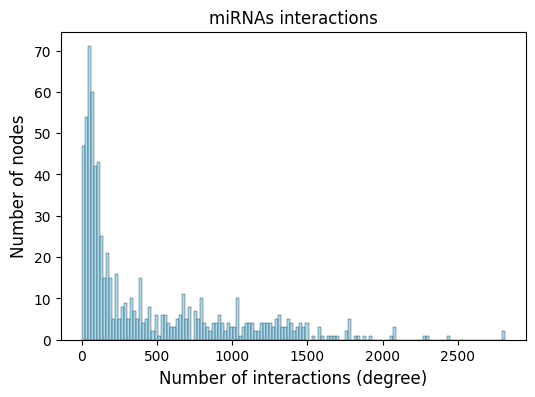

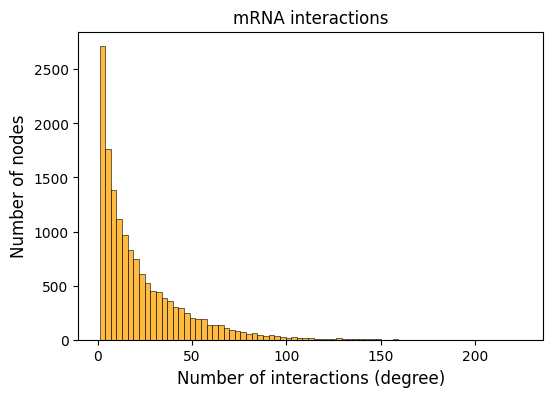

In [40]:
def get_bins(degrees, width):
    max_degree = max(degrees)
    return np.arange(0, max_degree + width, width)


# histogram for miRNAs connections
plt.figure(figsize=(6,4))
bin_width = 5 
sns.histplot(source_degrees, binwidth=20, 
             color='skyblue', edgecolor='black', kde=False)
plt.xlabel('Number of interactions (degree)', fontsize=12)
plt.ylabel('Number of nodes', fontsize=12)
plt.title(f'miRNAs interactions')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('thesis_plots/mirna_n_MTI.png', dpi=300, bbox_inches='tight')
plt.show()

# histogram for Target Gene connections
plt.figure(figsize=(6,4))
sns.histplot(target_degrees, binwidth=3, 
             color='orange', edgecolor='black', kde=False)
plt.xlabel('Number of interactions (degree)', fontsize=12)
plt.ylabel('Number of nodes', fontsize=12)
plt.title(f'mRNA interactions')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('thesis_plots/genes_n_MTI.png', dpi=300, bbox_inches='tight')
plt.show()